This notebook is for exploring various k-means and Gaussian Mixture Model results based on a variety of inputs, including raw band stacks, shadow and building masks, etc. 

Required inputs created by running 'explorations_calculating_spectral_indices_beira.ipynb'

In [1]:
%matplotlib inline

In [2]:
# Import necessary packages
import os
import sys
import pickle
from glob import glob
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.ndimage import generic_filter
import rasterio as rio
from rasterio.mask import mask
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

# Establish path for modules
sys.path.insert(0, '..\\modules\\')

# Import modules with custom functions
import calc_array_mask_test
import morph_indices

# Set font sizes for plots
plt.rc('figure', titlesize=24)
plt.rc('axes', titlesize=16)

### Note: update "aoi" parameter and band_path with directory name for imagery of interest

In [5]:
# Identify area of interest (aoi), set directories for inputs and outputs
aoi = "beira_ps"

# Define paths to bands
band_path = '..\\data\\'+aoi+"\\"
outputs_path= os.path.join(band_path, "explorations_outputs\\raster_files\\")
kmeans_outputs_path = os.path.join(band_path, "explorations_outputs\\kmeans\\")
try:
    os.makedirs(kmeans_outputs_path)
except FileExistsError:
    print("band_path directory already exists!")

band_path directory already exists!


In [7]:
# Create raster stack of all bands
all_dg_bands = glob(band_path+"*band_*")
all_dg_bands.sort()
all_bands_path = os.path.join(outputs_path, aoi + "_all_bands.tif")
all_bands, all_bands_meta = es.stack(all_dg_bands,
                                             all_bands_path)

In [8]:
# Open raster stack and make copies of meta file for use in writing out files later
with rio.open(all_bands_path) as src:
    all_bands_stack = src.read()
    stack_meta = src.meta
    files_out_meta = src.meta.copy()
    masks_out_meta = src.meta.copy()
    stack_out_meta = src.meta.copy()

In [9]:
# Update files_out_meta for writing out single files
files_out_meta['count']=1

# Update masks_out_meta for writing single integer type files
masks_out_meta['dtype'] = 'int32'
masks_out_meta['count'] = 1

# Update stack_out_meta for writing out cloud masked band stack
stack_out_meta['nodata']=-99999

In [10]:
# Read in indices for stacking
dark_path = outputs_path+'dark.tif'
with rio.open(dark_path) as src:
    dark = src.read()
mbi_path = outputs_path+'mbi.tif'
with rio.open(mbi_path) as src:
    mbi = src.read()
msi_path = outputs_path+'msi.tif'
with rio.open(msi_path) as src:
    msi = src.read()
ndvi_path = outputs_path+'ndvi.tif'
with rio.open(ndvi_path) as src:
    ndvi = src.read()
ndwi_path = outputs_path+'raw_ndwi_yellow.tif'
with rio.open(ndwi_path) as src:
    ndwi = src.read()
ndwi_msi = ndwi-msi

In [11]:
# Create stacks of indices for kmeans explorations
stack = [dark,mbi,msi,ndvi,ndwi]
index_stack = np.vstack(stack)

small_stack = [msi,ndvi,ndwi]
index_small_stack = np.vstack(small_stack)

small_stack_plus = [msi,ndvi,ndwi,ndwi_msi]
index_small_stack = np.vstack(small_stack_plus)

In [12]:
# Read in index masks
building_mask_path = outputs_path+'building_mask.tif'
with rio.open(building_mask_path) as src:
    building_mask = src.read()
shadow_mask_path = outputs_path+'shadow_mask.tif'
with rio.open(shadow_mask_path) as src:
    shadow_mask = src.read()
vegetation_mask_path = outputs_path+'vegetation_mask.tif'
with rio.open(vegetation_mask_path) as src:
    vegetation_mask = src.read()
flood_mask_path = outputs_path+'flood_combo_mask.tif'
with rio.open(flood_mask_path) as src:
    flood_mask = src.read()

In [13]:
# Create stacks of indices for kmeans explorations
stack = [building_mask, shadow_mask, vegetation_mask, flood_mask]
mask_stack = np.vstack(stack)

stack_mask_all = [all_bands_stack, mask_stack]
band_mask_stack = np.vstack(stack_mask_all)

stack_all = [all_bands_stack, index_stack]
band_index_stack = np.vstack(stack_all)

# Define k-means classifier. User can change number of output cluster (nclass)

In [14]:
# Define kmeans classifier
nclass = 7
clf_kmeans = KMeans(n_clusters=nclass, random_state=10)
pickle.dump(clf_kmeans,open(kmeans_outputs_path+'pickle_kmeans', 'wb'))

# Exploring k-means results with varying inputs

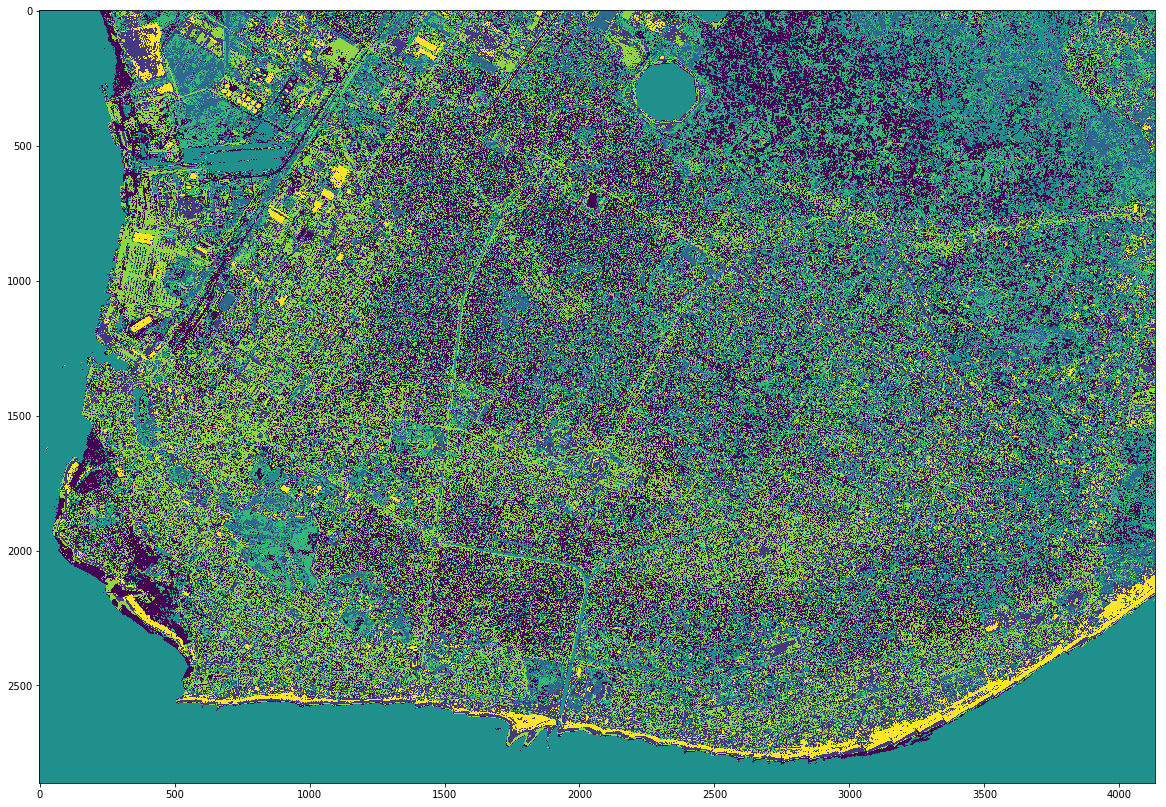

In [15]:
# Run k-means on the 8-band raster stack
all_bands_im = np.rollaxis(all_bands_stack, 0, 3)
X_all_bands_stack = all_bands_im.reshape(-1,8)# Fit the KMeans classifier to the 8-band raster stack
predictedClass_all_bands = clf_kmeans.fit_predict(X_all_bands_stack, y=None)
predictedClass_all_bands += 1

# Plot the result
fig, ax = plt.subplots(figsize = (20,20))
pred_data_all_bands = predictedClass_all_bands.reshape(all_bands_im.shape[:2])
ax.imshow(pred_data_all_bands)
plt.show()


# Write out kmeans result
with rio.open(kmeans_outputs_path+'kmeans_all_bands.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data_all_bands.astype('float32'),1)

In [ ]:
# Adding texture band for all_bands stack
radius = 5
all_bands_im = np.rollaxis(all_bands, 0, 3)
texture = generic_filter(all_bands_im[:,:,1], np.std, size=2*radius)
texture_newaxis = texture[np.newaxis,:]
bands_and_texture = np.vstack((all_bands, texture_newaxis))
all_bands_text_im = np.rollaxis(bands_and_texture,0,3)
X_text = all_bands_text_im.reshape(-1,9)

# fit the KMeans classifier to shadow and building masks stack with texture 
predictedClass_text = clf_kmeans.fit_predict(X_text, y=None)
predictedClass_text += 1

## Plot the result
fig, ax = plt.subplots(figsize = (40,40))
pred_data_text = predictedClass_text.reshape(all_bands_text_im.shape[:2])
im = ax.imshow(pred_data_text)
plt.show()

# Write out kmeans result
with rio.open(kmeans_outputs_path+'kmeans_all_bands_texture.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data_text.astype('float32'),1)

In [ ]:
# # plt.scatter(X_all_bands_stack[:, 0], X_all_bands_stack[:, 1], c=predictedClass_all_bands, s=50, cmap='viridis')

# centers = clf_kmeans.cluster_centers_
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [ ]:
# clf_kmeans.fit(X_index_small_stack)
# centers = clf_kmeans.cluster_centers_
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [ ]:
# Run k-means on the index raster small stack
index_small_stack_im = np.rollaxis(index_small_stack, 0, 3)
X_index_small_stack = index_small_stack_im.reshape(-1,4)# Fit the KMeans classifier to the 8-band raster stack
predictedClass_index_small_stack = clf_kmeans.fit_predict(X_index_small_stack, y=None)
predictedClass_index_small_stack += 1

# Plot the result
fig, ax = plt.subplots(figsize = (20,20))
pred_data_index_small_stack = predictedClass_index_small_stack.reshape(index_small_stack_im.shape[:2])
ax.imshow(pred_data_index_small_stack)
plt.show()

# Write out kmeans result
with rio.open(kmeans_outputs_path+'kmeans_index_small_stack.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data_index_small_stack.astype('float32'),1)

In [ ]:
# Run k-means on the index raster stack
index_stack_im = np.rollaxis(index_stack, 0, 3)
X_index_stack = index_stack_im.reshape(-1,5)# Fit the KMeans classifier to the 8-band raster stack
predictedClass_index_stack = clf_kmeans.fit_predict(X_index_stack, y=None)
predictedClass_index_stack += 1

# Plot the result
fig, ax = plt.subplots(figsize = (20,20))
pred_data_index_stack = predictedClass_index_stack.reshape(index_stack_im.shape[:2])
ax.imshow(pred_data_index_stack)
plt.show()

# Write out kmeans result
with rio.open(kmeans_outputs_path+'kmeans_index_stack.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data_index_stack.astype('float32'),1)

In [ ]:
# Run k-means on the mask plus 8 band raster stack
band_index_stack_im = np.rollaxis(band_index_stack, 0, 3)
X_band_index_stack = band_index_stack_im.reshape(-1,13)# Fit the KMeans classifier to the 8-band raster stack
predictedClass_band_index_stack = clf_kmeans.fit_predict(X_band_index_stack, y=None)
predictedClass_band_index_stack += 1

# Plot the result
fig, ax = plt.subplots(figsize = (20,20))
pred_data_band_index_stack = predictedClass_band_index_stack.reshape(band_index_stack_im.shape[:2])
ax.imshow(pred_data_band_index_stack)
plt.show()

# Write out kmeans result
with rio.open(kmeans_outputs_path+'kmeans_band_index_stack_8clusters.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data_band_index_stack.astype('float32'),1)

In [ ]:
# Run k-means on the mask plus 8 band raster stack
band_mask_stack_im = np.rollaxis(band_mask_stack, 0, 3)
X_band_mask_stack = band_mask_stack_im.reshape(-1,12)# Fit the KMeans classifier to the 8-band raster stack
predictedClass_band_mask_stack = clf_kmeans.fit_predict(X_band_mask_stack, y=None)
predictedClass_band_mask_stack += 1

# Plot the result
fig, ax = plt.subplots(figsize = (20,20))
pred_data_band_mask_stack = predictedClass_band_mask_stack.reshape(band_mask_stack_im.shape[:2])
ax.imshow(pred_data_band_mask_stack)
plt.show()

# Write out kmeans result
with rio.open(kmeans_outputs_path+'kmeans_band_mask_stack.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data_band_mask_stack.astype('float32'),1)

In [ ]:
all_bands_msi = np.vstack((all_bands,msi))
# Run k-means on the mask plus 8 band raster stack
all_bands_msi_im = np.rollaxis(all_bands_msi, 0, 3)
X_all_bands_msi = all_bands_msi_im.reshape(-1,9)# Fit the KMeans classifier to the 8-band raster stack
predictedClass_all_bands_msi = clf_kmeans.fit_predict(X_all_bands_msi, y=None)
predictedClass_all_bands_msi += 1

# Plot the result
fig, ax = plt.subplots(figsize = (20,20))
pred_data_all_bands_msi = predictedClass_all_bands_msi.reshape(all_bands_msi_im.shape[:2])
ax.imshow(pred_data_all_bands_msi)
plt.show()

# Write out kmeans result
with rio.open(kmeans_outputs_path+'kmeans_all_bands_msi.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data_all_bands_msi.astype('float32'),1)

In [ ]:
# Run k-means on the mask raster stack
mask_stack_im = np.rollaxis(mask_stack, 0, 3)
X_mask_stack = mask_stack_im.reshape(-1,4)# Fit the KMeans classifier to the 8-band raster stack
predictedClass_mask_stack = clf_kmeans.fit_predict(X_mask_stack, y=None)
predictedClass_mask_stack += 1

# Plot the result
fig, ax = plt.subplots(figsize = (20,20))
pred_data_mask_stack = predictedClass_mask_stack.reshape(mask_stack_im.shape[:2])
ax.imshow(pred_data_mask_stack)
plt.show()

# Write out kmeans result
with rio.open(kmeans_outputs_path+'kmeans_mask_stack.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data_mask_stack.astype('float32'),1)

In [ ]:
# Import raster stacks for k-means explorations
shadow_masked_band_stack_path = outputs_path+'shadow_masked_stack.tif'
with rio.open(shadow_masked_band_stack_path) as src:
    all_bands_shadow_free = src.read()
    all_bands_shadow_free_meta = src.meta

cloud_masked_band_stack_path = outputs_path+'all_bands_cl_free_koumassi_focus_ps.tif'
with rio.open(cloud_masked_band_stack_path) as src:
    all_bands_cl_free = src.read()
    all_bands_cl_free_meta = src.meta

shadow_mask_path = outputs_path+'msi_shadow_mask.tif'
with rio.open(shadow_mask_path) as src:
    shadow_mask = src.read()
    shadow_mask_meta = src.meta
    
building_mask_path = outputs_path+'building_mask.tif'
with rio.open(building_mask_path) as src:
    building_mask = src.read()
    building_mask_meta = src.meta
    
shadow_mask_apply = np.squeeze(shadow_mask)

In [ ]:
# Run k-means on all_bands_shadow_free, plot and write out result
shadow_free_bands_im = np.rollaxis(all_bands_shadow_free, 0, 3)
X_shadow_free = shadow_free_bands_im.reshape(-1,8)# Fit the KMeans classifier to the 8-band raster stack
predictedClass_shadow_free = clf_kmeans.fit_predict(X_shadow_free, y=None)
predictedClass_shadow_free += 1

# Plot the result
fig, ax = plt.subplots(figsize = (20,20))
pred_data_shadow_free = predictedClass_shadow_free.reshape(shadow_free_bands_im.shape[:2])
im = ax.imshow(pred_data_shadow_free)
plt.show()

# Write out kmeans result
with rio.open(kmeans_outputs_path+'kmeans_shadow_free.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data_shadow_free.astype('float32'),1)

In [ ]:
# Apply shadow mask to resulting kmeans clusters from shadow masked band stack
kmeans_shadow_mask = calc_array_mask_test.apply_mask(mask_array = shadow_mask_apply, raster_input = pred_data_shadow_free)
kmeans_shadow_mask_plot = np.squeeze(kmeans_shadow_mask)
fig, ax = plt.subplots(figsize = (40,40))
im = ax.imshow(kmeans_shadow_mask_plot)
plt.show()

# Write out kmeans result
with rio.open(kmeans_outputs_path+'kmeans_shadow_free_shadow_mask_applied_after.tif', 'w', **files_out_meta) as dst:
    dst.write(kmeans_shadow_mask_plot.astype('float32'),1)

In [ ]:
# Run k-means on cloud masked stack, plot and write out result
cloud_free_bands_im = np.rollaxis(all_bands_cl_free, 0, 3)
X_cloud_free = cloud_free_bands_im.reshape(-1,8)# Fit the KMeans classifier to the 8-band raster stack
predictedClass_cloud_free = clf_kmeans.fit_predict(X_cloud_free, y=None)
predictedClass_cloud_free += 1

# Plot the result
fig, ax = plt.subplots(figsize = (40,40))
pred_data_cloud_free = predictedClass_cloud_free.reshape(cloud_free_bands_im.shape[:2])
im = ax.imshow(pred_data_cloud_free)
plt.show()

# Write out kmeans result
with rio.open(kmeans_outputs_path+'kmeans_cl_free.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data_cloud_free.astype('float32'),1)

In [ ]:
# Create and stacks combining shadow masked band stack and MSI and shadow mask
all_bands_shadow_free_msi = np.vstack((all_bands_shadow_free,msi))
all_bands_msi = np.vstack((all_bands,msi))
all_bands_shadow_free_shadow_mask = np.vstack((all_bands_shadow_free,shadow_mask))
all_bands_cl_free_msi = np.vstack((all_bands_cl_free,msi))
all_bands_cl_free_shadow_mask = np.vstack((all_bands_cl_free,shadow_mask))

In [ ]:
#Kmeans on shadow masked 8 bands plus raw values MSI
shadow_free_msi_bands_im = np.rollaxis(all_bands_shadow_free_msi, 0, 3)
X_shadow_free_msi = shadow_free_msi_bands_im .reshape(-1,9)# Fit the KMeans classifier to the 8-band raster stack
predictedClass_shadow_free_msi = clf_kmeans.fit_predict(X_shadow_free_msi, y=None)
predictedClass_shadow_free_msi += 1

# Plot the result
fig, ax = plt.subplots(figsize = (40,40))
pred_data_shadow_free_msi = predictedClass_shadow_free_msi.reshape(shadow_free_msi_bands_im.shape[:2])
im = ax.imshow(pred_data_shadow_free_msi)
plt.show()

# Write out kmeans result
with rio.open(kmeans_outputs_path+'kmeans_shadow_free_msi.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data_shadow_free_msi.astype('float32'),1)

In [ ]:
#Kmeans on cloud masked 8 bands plus raw values MSI
cloud_free_msi_bands_im = np.rollaxis(all_bands_cl_free_msi, 0, 3)
X_cloud_free_msi = cloud_free_msi_bands_im.reshape(-1,9)# Fit the KMeans classifier to the 8-band raster stack
predictedClass_cloud_free_msi = clf_kmeans.fit_predict(X_cloud_free_msi, y=None)
predictedClass_cloud_free_msi += 1

# Plot the result
fig, ax = plt.subplots(figsize = (40,40))
pred_cloud_free_msi = predictedClass_cloud_free_msi.reshape(cloud_free_msi_bands_im.shape[:2])
im = ax.imshow(pred_cloud_free_msi)
plt.show()

# Write out kmeans result
with rio.open(kmeans_outputs_path+'kmeans_cl_free_msi.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_cloud_free_msi.astype('float32'),1)

In [ ]:
# Kmeans on shadow masked 8 bands plus shadow mask
shadow_free_shadow_mask_bands_im = np.rollaxis(all_bands_shadow_free_shadow_mask, 0, 3)
X_shadow_free_shadow_mask = shadow_free_shadow_mask_bands_im.reshape(-1,9)# Fit the KMeans classifier to the 8-band raster stack
predictedClass_shadow_free_shadow_mask = clf_kmeans.fit_predict(X_shadow_free_shadow_mask, y=None)
predictedClass_shadow_free_shadow_mask += 1

## Plot the result
fig, ax = plt.subplots(figsize = (40,40))
pred_data_shadow_free_shadow_mask = predictedClass_shadow_free_shadow_mask.reshape(shadow_free_shadow_mask_bands_im.shape[:2])
im = ax.imshow(pred_data_shadow_free_shadow_mask)
plt.show()

# Write out kmeans result
with rio.open(kmeans_outputs_path+'kmeans_shadow_free_shadow_mask.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data_shadow_free_shadow_mask.astype('float32'),1)

In [ ]:
# Kmeans on cloud masked 8 bands plus shadow mask
cloud_free_bands_shadow_mask_im = np.rollaxis(all_bands_cl_free_shadow_mask, 0, 3)
X_cloud_free_shadow_mask= cloud_free_bands_shadow_mask_im.reshape(-1,9)# Fit the KMeans classifier to the 8-band raster stack
predictedClass_cloud_free_shadow_mask = clf_kmeans.fit_predict(X_cloud_free_shadow_mask, y=None)
clf_kmeans_cl_free_shadow_mask = clf_kmeans.fit(X_cloud_free_shadow_mask)
predictedClass_cloud_free_shadow_mask += 1

## Plot the result
fig, ax = plt.subplots(figsize = (40,40))
pred_data_cloud_free_shadow_mask = predictedClass_cloud_free_shadow_mask.reshape(cloud_free_bands_shadow_mask_im.shape[:2])
im = ax.imshow(pred_data_cloud_free_shadow_mask)
plt.show()

# Write out kmeans result
with rio.open(kmeans_outputs_path+'kmeans_cl_free_shadow_mask.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data_cloud_free_shadow_mask.astype('float32'),1)

In [ ]:
# clf_kmeans_cl_free_shadow_mask = clf_kmeans.fit(X_cloud_free_shadow_mask)
# pickle.dump(clf_kmeans_cl_free_shadow_mask,open(kmeans_outputs_path+'pickle_kmeans_cl_free_shadow_mask', 'wb'))

## Exploring Kmeans with MBI and building mask added

In [ ]:
building_mask_stack = building_mask
all_bands_shadow_free_shad_build_mask = np.vstack((all_bands_shadow_free_shadow_mask,building_mask_stack))
all_bands_shadow_free_build_mask = np.vstack((all_bands_shadow_free,building_mask_stack))
all_bands_cl_free_shad_build_mask = np.vstack((all_bands_cl_free_shadow_mask,building_mask_stack))
all_bands_cl_free_build_mask = np.vstack((all_bands_cl_free,building_mask_stack))

In [ ]:
# Kmeans with shadow free and shadow and building masks
shadow_bands_shad_build_mask_im = np.rollaxis(all_bands_shadow_free_shad_build_mask, 0, 3)
X_shadow_free_shad_build_mask = shadow_bands_shad_build_mask_im.reshape(-1,10)# Fit the KMeans classifier to the 8-band raster stack
predictedClass_shadow_free_shad_build_mask = clf_kmeans.fit_predict(X_shadow_free_shad_build_mask , y=None)
predictedClass_shadow_free_shad_build_mask += 1

# Plot the result
fig, ax = plt.subplots(figsize = (40,40))
pred_data_shadow_free_shad_build_mask = predictedClass_shadow_free_shad_build_mask.reshape(shadow_bands_shad_build_mask_im.shape[:2])
im = ax.imshow(pred_data_shadow_free_shad_build_mask)
plt.show()

# Write out kmeans result
with rio.open(kmeans_outputs_path+'kmeans_with_shadow_build_mask.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data_shadow_free_shad_build_mask.astype('float32'),1)

In [ ]:
# Kmeans with cloud free and shadow and building masks 
cloud_bands_shad_build_mask_im = np.rollaxis(all_bands_cl_free_shad_build_mask, 0, 3)
X_cloud_free_shad_build_mask = cloud_bands_shad_build_mask_im.reshape(-1,10)# Fit the KMeans classifier to the 8-band raster stack
predictedClass_cloud_free_shad_build_mask= clf_kmeans.fit_predict(X_cloud_free_shad_build_mask, y=None)
predictedClass_cloud_free_shad_build_mask += 1


# Plot the result
fig, ax = plt.subplots(figsize = (40,40))
pred_data_cloud_bands_shad_build_mask = predictedClass_cloud_free_shad_build_mask.reshape(cloud_bands_shad_build_mask_im.shape[:2])
im = ax.imshow(pred_data_cloud_bands_shad_build_mask)

# Write out kmeans result
with rio.open(kmeans_outputs_path+'kmeans_with_shadow_build_mask_cl_free.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data_cloud_bands_shad_build_mask.astype('float32'),1)

#  Try Gaussian Mixture Model

In [ ]:
from sklearn.mixture import GaussianMixture
clf_gm = GaussianMixture(n_components=7)

In [ ]:
# Fit the GMM classifier to the 8-band stack
predictedClass_gm = clf_gm.fit_predict(X_all_bands_stack, y=None)
predictedClass_gm += 1

## Plot the result
fig, ax = plt.subplots(figsize = (40,40))
pred_data_gm = predictedClass_gm.reshape(all_bands_im.shape[:2])
ax.imshow(pred_data_gm)
plt.show()

# Write out GMM result
with rio.open(kmeans_outputs_path+'gmm_all_bands.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data_gm.astype('float32'),1)

In [ ]:
# Fit the GMM classifier to the 8-band cloud free stack
predictedClass_gm = clf_gm.fit_predict(X_cloud_free, y=None)
predictedClass_gm += 1

# Plot the result
fig, ax = plt.subplots(figsize = (40,40))
pred_data_gm = predictedClass_gm.reshape(cloud_free_bands_im.shape[:2])
ax.imshow(pred_data_gm)
plt.show()

# Write out GMM result
with rio.open(kmeans_outputs_path+'gmm_cl_free_bands.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data_gm.astype('float32'),1)

In [ ]:
# Fit the GMM classifier to the 8-band shadow free stack
predictedClass_shadow_free_gmm = clf_gm.fit_predict(X_shadow_free, y=None)
predictedClass_shadow_free_gmm += 1

# Plot the result
fig, ax = plt.subplots(figsize = (20,20))
pred_data_shadow_free_gmm = predictedClass_shadow_free_gmm.reshape(shadow_free_bands_im.shape[:2])
im = ax.imshow(pred_data_shadow_free_gmm)
plt.title("K-means - 8 clusters - 8 bands", fontsize=15)
plt.show()

# Write out GMM result
with rio.open(kmeans_outputs_path+'gmm_shadow_free.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data_shadow_free_gmm.astype('float32'),1)

In [ ]:
# Fit the GMM classifier to the 8-band shadow free stack plus shadow mask
predictedClass_shadow_free_shadow_mask_gmm = clf_gm.fit_predict(X_shadow_free_shadow_mask, y=None)
predictedClass_shadow_free_shadow_mask_gmm += 1

## Plot the result
fig, ax = plt.subplots(figsize = (40,40))
pred_data_shadow_free_shadow_mask_gmm = predictedClass_shadow_free_shadow_mask_gmm.reshape(shadow_free_shadow_mask_bands_im.shape[:2])
im = ax.imshow(pred_data_shadow_free_shadow_mask_gmm)
plt.show()

# Write out GMM result
with rio.open(kmeans_outputs_path+'gmm_shadow_free_shadow_mask.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data_shadow_free_shadow_mask_gmm.astype('float32'),1)